#  1.Importing Libraries

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from imblearn.over_sampling import RandomOverSampler


# 2.Bring the Data

In [56]:
df = pd.read_csv('heart_dirty.csv')
print(f"Initial shape: {df.shape}")
df.head()

Initial shape: (711, 12)


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,65.0,M,ASY,140.0,306.0,1.0,Normal,87.0,Y,1.5,Flat,1.0
1,59.0,M,ASY,120.0,0.0,0.0,Normal,115.0,N,0.0,Flat,1.0
2,56.0,F,ASY,134.0,409.0,0.0,LVH,150.0,Y,1.9,Flat,1.0
3,49.0,M,ASY,128.0,212.0,0.0,Normal,96.0,Y,0.0,Flat,1.0
4,65.0,M,ASY,144.0,312.0,0.0,LVH,113.0,Y,1.7,Flat,1.0


In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 711 entries, 0 to 710
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             682 non-null    float64
 1   Sex             683 non-null    object 
 2   ChestPainType   681 non-null    object 
 3   RestingBP       680 non-null    float64
 4   Cholesterol     673 non-null    float64
 5   FastingBS       680 non-null    float64
 6   RestingECG      683 non-null    object 
 7   MaxHR           677 non-null    float64
 8   ExerciseAngina  682 non-null    object 
 9   Oldpeak         683 non-null    float64
 10  ST_Slope        681 non-null    object 
 11  HeartDisease    680 non-null    float64
dtypes: float64(7), object(5)
memory usage: 66.8+ KB


In [58]:
df.shape

(711, 12)

# 3.Check Missing Values"

In [59]:
print("\nMissing values per column:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])
print(f"\nTotal missing values: {df.isnull().sum().sum()}")


Missing values per column:
Age               29
Sex               28
ChestPainType     30
RestingBP         31
Cholesterol       38
FastingBS         31
RestingECG        28
MaxHR             34
ExerciseAngina    29
Oldpeak           28
ST_Slope          30
HeartDisease      31
dtype: int64

Total missing values: 367


# 4. Handle Missing Values

In [60]:
numerical_cols = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak', 'FastingBS']
categorical_cols = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
target_col = 'HeartDisease'

rows_before = df.shape[0]
df = df.dropna(how='all')
rows_dropped_all_missing = rows_before - df.shape[0]
if rows_dropped_all_missing > 0:
    print(f" Removed {rows_dropped_all_missing} rows where ALL values were missing")

imputer_numeric = SimpleImputer(strategy='median')
df[numerical_cols] = imputer_numeric.fit_transform(df[numerical_cols])
print(" Numerical columns imputed with median")

imputer_categorical = SimpleImputer(strategy='most_frequent')
df[categorical_cols] = imputer_categorical.fit_transform(df[categorical_cols])
print(" Categorical columns imputed with most frequent value")

if df[target_col].isnull().sum() > 0:
    target_imputer = SimpleImputer(strategy='most_frequent')
    df[target_col] = target_imputer.fit_transform(df[[target_col]]).ravel()
    print(" Target column imputed with most frequent value")

print(f"\nMissing values after imputation: {df.isnull().sum().sum()}")


if df.isnull().sum().sum() == 0:
    print(" SUCCESS: All missing values handled properly!")
else:
    print(" WARNING: Some missing values still remain:")
    print(df.isnull().sum()[df.isnull().sum() > 0])

 Removed 28 rows where ALL values were missing
 Numerical columns imputed with median
 Categorical columns imputed with most frequent value
 Target column imputed with most frequent value

Missing values after imputation: 0
 SUCCESS: All missing values handled properly!


# 5.Handle Duplicates and Empty Rows

In [61]:
print(f"Shape before removing duplicates: {df.shape}")
initial_rows = df.shape[0]

df = df.drop_duplicates()
duplicates_removed = initial_rows - df.shape[0]
print(f" Duplicates removed: {duplicates_removed}")
print(f" Shape after removing duplicates: {df.shape}")

df = df.dropna(how='all')
print(f" Final shape: {df.shape}")

Shape before removing duplicates: (683, 12)
 Duplicates removed: 173
 Shape after removing duplicates: (510, 12)
 Final shape: (510, 12)


# 6. Handle Text Inconsistencies

In [62]:
print("\nBefore fixing Sex column:")
print(df['Sex'].value_counts())

df['Sex'] = df['Sex'].replace({'m': 'M', 'f': 'F', 'male': 'M', 'female': 'F'})
print("\nAfter fixing Sex column:")
print(df['Sex'].value_counts())

# Standardize all categorical columns (strip whitespace, uppercase)
for col in categorical_cols:
    if col in df.columns:
        df[col] = df[col].astype(str).str.strip().str.upper()
        print(f" Standardized {col} done")


Before fixing Sex column:
Sex
M    442
F     68
Name: count, dtype: int64

After fixing Sex column:
Sex
M    442
F     68
Name: count, dtype: int64
 Standardized Sex done
 Standardized ChestPainType done
 Standardized RestingECG done
 Standardized ExerciseAngina done
 Standardized ST_Slope done


# 7. Convert Data Types

In [63]:
for col in numerical_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

for col in categorical_cols:
    df[col] = df[col].astype(str)

df[target_col] = df[target_col].astype(int)

print("\nData types:")
print(df.dtypes)


Data types:
Age               float64
Sex                object
ChestPainType      object
RestingBP         float64
Cholesterol       float64
FastingBS         float64
RestingECG         object
MaxHR             float64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object


# 8. Validate and Fill Categorical Values

In [64]:
valid_sex = ['M', 'F']
valid_chest_pain = ['ATA', 'NAP', 'ASY', 'TA']
valid_resting_ecg = ['NORMAL', 'ST', 'LVH']
valid_exercise_angina = ['Y', 'N']
valid_st_slope = ['UP', 'FLAT', 'DOWN']


initial_shape = df.shape[0]

# Filter out invalid values (keep valid values OR NaN for later imputation)
df = df[df['Sex'].isin(valid_sex) | df['Sex'].isna()]
df = df[df['ChestPainType'].isin(valid_chest_pain) | df['ChestPainType'].isna()]
df = df[df['RestingECG'].isin(valid_resting_ecg) | df['RestingECG'].isna()]
df = df[df['ExerciseAngina'].isin(valid_exercise_angina) | df['ExerciseAngina'].isna()]
df = df[df['ST_Slope'].isin(valid_st_slope) | df['ST_Slope'].isna()]

rows_removed = initial_shape - df.shape[0]
print(f"✓ Removed {rows_removed} rows with invalid categorical values")

if df['Sex'].isna().any():
    df['Sex'] = df['Sex'].fillna(df['Sex'].mode()[0] if len(df['Sex'].mode()) > 0 else 'M')
    print("✓ Filled missing Sex values with mode")

if df['ChestPainType'].isna().any():
    df['ChestPainType'] = df['ChestPainType'].fillna(df['ChestPainType'].mode()[0] if len(df['ChestPainType'].mode()) > 0 else 'ASY')
    print("✓ Filled missing ChestPainType values with mode")

if df['RestingECG'].isna().any():
    df['RestingECG'] = df['RestingECG'].fillna(df['RestingECG'].mode()[0] if len(df['RestingECG'].mode()) > 0 else 'NORMAL')
    print("✓ Filled missing RestingECG values with mode")

if df['ExerciseAngina'].isna().any():
    df['ExerciseAngina'] = df['ExerciseAngina'].fillna(df['ExerciseAngina'].mode()[0] if len(df['ExerciseAngina'].mode()) > 0 else 'N')
    print("✓ Filled missing ExerciseAngina values with mode")

if df['ST_Slope'].isna().any():
    df['ST_Slope'] = df['ST_Slope'].fillna(df['ST_Slope'].mode()[0] if len(df['ST_Slope'].mode()) > 0 else 'FLAT')
    print("✓ Filled missing ST_Slope values with mode")

print(f"\nFinal shape after validation: {df.shape}")
print(f"\nFinal missing values:")
print(df.isnull().sum())

# Check unique values AFTER validation
for col in categorical_cols:
    print(f"\n{col} unique values:")
    print(df[col].value_counts())
    
print("\n All categorical values validated and cleaned!")



✓ Removed 0 rows with invalid categorical values

Final shape after validation: (510, 12)

Final missing values:
Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

Sex unique values:
Sex
M    442
F     68
Name: count, dtype: int64

ChestPainType unique values:
ChestPainType
ASY    362
NAP     85
ATA     42
TA      21
Name: count, dtype: int64

RestingECG unique values:
RestingECG
NORMAL    296
ST        110
LVH       104
Name: count, dtype: int64

ExerciseAngina unique values:
ExerciseAngina
Y    288
N    222
Name: count, dtype: int64

ST_Slope unique values:
ST_Slope
FLAT    348
UP      107
DOWN     55
Name: count, dtype: int64

 All categorical values validated and cleaned!


# 9. Encode Categorical Variables with OneHotEncoder

In [65]:
# Label Encoding for binary columns
label_encoders = {}
binary_cols = ['Sex', 'ExerciseAngina']

for col in binary_cols:
    if col in df.columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le
        print(f"\n{col} encoding: {dict(zip(le.classes_, le.transform(le.classes_)))}")

# One-hot encoding for multi-class columns
multi_class_cols = [col for col in ['ChestPainType', 'RestingECG', 'ST_Slope'] if col in df.columns]

if multi_class_cols:
    df = pd.get_dummies(df, columns=multi_class_cols, drop_first=True)
    print(f"\n One-hot encoded: {multi_class_cols}")

print(f"Final shape: {df.shape}")
print(f"\nColumns after encoding: {list(df.columns)}")


Sex encoding: {'F': np.int64(0), 'M': np.int64(1)}

ExerciseAngina encoding: {'N': np.int64(0), 'Y': np.int64(1)}

 One-hot encoded: ['ChestPainType', 'RestingECG', 'ST_Slope']
Final shape: (510, 16)

Columns after encoding: ['Age', 'Sex', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'HeartDisease', 'ChestPainType_ATA', 'ChestPainType_NAP', 'ChestPainType_TA', 'RestingECG_NORMAL', 'RestingECG_ST', 'ST_Slope_FLAT', 'ST_Slope_UP']


# 10. Display Encoded Data

In [66]:
print("Encoded data preview:")
df.head(10)

Encoded data preview:


,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,HeartDisease,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_NORMAL,RestingECG_ST,ST_Slope_FLAT,ST_Slope_UP
0,65.0,1,140.0,306.0,1.0,87.0,1,1.5,1,False,False,False,True,False,True,False
1,59.0,1,120.0,0.0,0.0,115.0,0,0.0,1,False,False,False,True,False,True,False
2,56.0,0,134.0,409.0,0.0,150.0,1,1.9,1,False,False,False,False,False,True,False
3,49.0,1,128.0,212.0,0.0,96.0,1,0.0,1,False,False,False,True,False,True,False
4,65.0,1,144.0,312.0,0.0,113.0,1,1.7,1,False,False,False,False,False,True,False
5,62.0,1,115.0,0.0,1.0,72.0,1,-0.5,1,False,False,False,True,False,True,False
6,64.0,1,110.0,0.0,1.0,114.0,1,1.3,1,False,False,False,True,False,False,False
7,49.0,1,130.0,206.0,0.0,170.0,0,0.0,1,False,False,False,True,False,True,False
8,58.0,1,132.0,224.0,0.0,173.0,0,3.2,1,False,True,False,False,False,False,True
9,60.0,1,117.0,230.0,1.0,160.0,1,1.4,1,False,False,False,True,False,False,True


# 11. add features engeenering

In [67]:
# Create only the most important interaction features
df['age_oldpeak'] = df['Age'] * df['Oldpeak']
df['MaxHR_age'] = df['MaxHR'] / (df['Age'] + 1)  # Avoid division by zero

print("✓ Created 2 key interaction features")
print(f"New shape: {df.shape}")


✓ Created 2 key interaction features
New shape: (510, 18)


# 12.Check Imbalance in Target Column

In [68]:
print("\nTarget variable distribution:")
target_distribution = df[target_col].value_counts()
print(target_distribution)
imbalance_ratio = target_distribution.min() / target_distribution.max()
print(f"\nImbalance ratio: {imbalance_ratio:.2f}")
if imbalance_ratio < 0.8:
    print(" Dataset is imbalanced! Will apply oversampling.")
else:
    print(" Dataset is relatively balanced.")



Target variable distribution:
HeartDisease
1    444
0     66
Name: count, dtype: int64

Imbalance ratio: 0.15
 Dataset is imbalanced! Will apply oversampling.


# 13. Split The Data

In [69]:
X = df.drop(target_col, axis=1)
y = df[target_col]

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Features shape: (510, 17)
Target shape: (510,)
Train shape: (408, 17), Test shape: (102, 17)


# 14. Handle Outliers 

In [70]:
for col in ['Cholesterol', 'RestingBP', 'Age', 'MaxHR','Oldpeak' ]:
    Q1 = X_train[col].quantile(0.25)
    Q3 = X_train[col].quantile(0.75)
    IQR = Q3 - Q1
    upper_bound = Q3 + 1.5 * IQR
    lower_bound = Q1 - 1.5 * IQR
    
    # Cap outliers
    X_train[col] = np.where(X_train[col] > upper_bound, upper_bound, X_train[col])
    X_train[col] = np.where(X_train[col] < lower_bound, lower_bound, X_train[col])
    print(f" Handled outliers in {col} (Lower: {lower_bound:.2f}, Upper: {upper_bound:.2f})")

 Handled outliers in Cholesterol (Lower: -397.88, Upper: 663.12)
 Handled outliers in RestingBP (Lower: 84.00, Upper: 180.00)
 Handled outliers in Age (Lower: 31.00, Upper: 79.00)
 Handled outliers in MaxHR (Lower: 62.50, Upper: 194.50)
 Handled outliers in Oldpeak (Lower: -3.00, Upper: 5.00)


# 15. Balance Data by SMOTE

In [71]:
if imbalance_ratio < 0.8:
    smote = SMOTE(random_state=42, k_neighbors=5)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
    
    print(f" Training set before SMOTE: {X_train.shape[0]} samples")
    print(f" Training set after SMOTE: {X_train_balanced.shape[0]} samples")
    print(f"\nBalanced target distribution:")
    print(y_train_balanced.value_counts())
    
    X_train = X_train_balanced
    y_train = y_train_balanced

 Training set before SMOTE: 408 samples
 Training set after SMOTE: 710 samples

Balanced target distribution:
HeartDisease
1    355
0    355
Name: count, dtype: int64


# 16. Scaling Features

In [72]:
scaler = StandardScaler()
cols_to_scale = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

# Fit on training data and transform both train and test
X_train[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
X_test[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

print(" Features scaled using StandardScaler")
print("\nScaled training data (first 5 rows):")
print(X_train.head())

 Features scaled using StandardScaler

Scaled training data (first 5 rows):
        Age  Sex  RestingBP  Cholesterol  FastingBS     MaxHR  ExerciseAngina  \
0  0.519029    1  -0.267123    -1.917822        1.0  0.431993               1   
1  0.846274    1  -0.135466     0.116227        0.0 -0.211641               1   
2  0.519029    1   0.522818     0.649425        1.0  0.110176               0   
3  1.282600    1   0.786132    -1.917822        0.0 -0.613913               1   
4  1.064437    0   0.391161     0.985142        1.0 -1.257547               0   

    Oldpeak  ChestPainType_ATA  ChestPainType_NAP  ChestPainType_TA  \
0  0.192080              False              False             False   
1  1.557437              False              False             False   
2 -0.783174               True              False             False   
3  0.192080              False              False             False   
4  1.069809              False              False             False   

   Resting

# 17. Build KNN Model

In [73]:
# Define parameter grid
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'p': [1, 2]
}

# Create base KNN classifier
knn_base = KNeighborsClassifier()

# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(
    knn_base,
    param_grid,
    cv=5,
    scoring='precision',  # Optimize for precision to reduce false positives
    n_jobs=-1,
    verbose=1
)

print(" Performing Grid Search (this may take a few minutes)...")
grid_search.fit(X_train, y_train)

# Get best model
knn_classifier = grid_search.best_estimator_

print("\n✓ Best Parameters Found:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")
print(f"\n✓ Best Cross-Validation Precision Score: {grid_search.best_score_:.4f}")

 Performing Grid Search (this may take a few minutes)...
Fitting 5 folds for each of 60 candidates, totalling 300 fits

✓ Best Parameters Found:
  metric: manhattan
  n_neighbors: 3
  p: 1
  weights: distance

✓ Best Cross-Validation Precision Score: 0.9656


# 18. Predict Test Set Results (KNN)

In [74]:
y_pred_knn = knn_classifier.predict(X_test)

print("✓ Predictions completed!")
print(f"\nFirst 10 predictions vs actual:")
comparison_df = pd.DataFrame({
    'Actual': y_test.values[:10],
    'Predicted': y_pred_knn[:10]
})
print(comparison_df)

✓ Predictions completed!

First 10 predictions vs actual:
   Actual  Predicted
0       1          1
1       1          0
2       0          0
3       1          1
4       1          1
5       1          1
6       1          1
7       1          1
8       1          1
9       1          1


# 19. Threshold Optimization

In [75]:
from sklearn.metrics import precision_score


y_pred_proba = knn_classifier.predict_proba(X_test)[:, 1]

# Test different thresholds
best_threshold = 0.5
best_precision = 0

for threshold in np.arange(0.3, 0.8, 0.05):
    y_pred_threshold = (y_pred_proba >= threshold).astype(int)
    precision = precision_score(y_test, y_pred_threshold)
    
    if precision > best_precision:
        best_precision = precision
        best_threshold = threshold

print(f" Optimal Threshold: {best_threshold:.2f}")
print(f" Precision at Optimal Threshold: {best_precision:.4f}")

# Use optimal threshold for final predictions
y_pred_knn = (y_pred_proba >= best_threshold).astype(int)



 Optimal Threshold: 0.35
 Precision at Optimal Threshold: 0.9647


# 20. Confusion Matrix (KNN)

In [76]:
cm_knn = confusion_matrix(y_test, y_pred_knn)
print("\nConfusion Matrix:")
print(cm_knn)

accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f"\n Accuracy: {accuracy_knn:.4f} ({accuracy_knn*100:.2f}%)")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_knn))


Confusion Matrix:
[[10  3]
 [ 7 82]]

 Accuracy: 0.9020 (90.20%)

Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.77      0.67        13
           1       0.96      0.92      0.94        89

    accuracy                           0.90       102
   macro avg       0.78      0.85      0.80       102
weighted avg       0.92      0.90      0.91       102



# 21. Visualize Confusion Matrix (KNN)

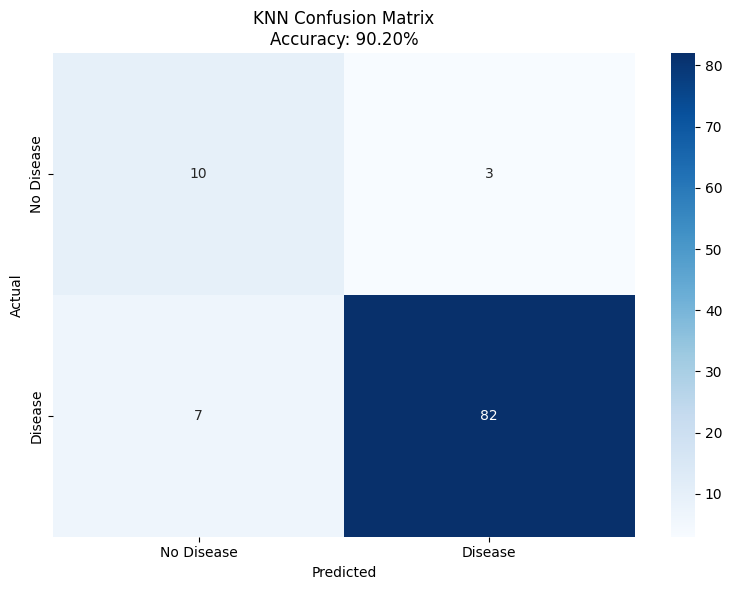

In [77]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Disease', 'Disease'],
            yticklabels=['No Disease', 'Disease'])
plt.title(f'KNN Confusion Matrix\nAccuracy: {accuracy_knn*100:.2f}%')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

# 22. Predict Heart Disease for New / Unseen Data (Interactive) 

In [78]:
def predict_heart_disease_interactive():
    print("Please enter patient information:")
    print()
    
    try:
        age = float(input("Enter Age (e.g., 45): "))
        resting_bp = float(input("Enter Resting Blood Pressure (e.g., 120): "))
        cholesterol = float(input("Enter Cholesterol level (e.g., 200): "))
        max_hr = float(input("Enter Maximum Heart Rate (e.g., 150): "))
        oldpeak = float(input("Enter Oldpeak (ST depression, e.g., 1.5): "))
        
        print("\nCategorical Information:")
        sex = input("Enter Sex (M/F): ").strip().upper()
        
        print("\nChest Pain Type options: ATA, NAP, ASY, TA")
        chest_pain = input("Enter Chest Pain Type: ").strip().upper()
        
        print("\nResting ECG options: NORMAL, ST, LVH")
        resting_ecg = input("Enter Resting ECG: ").strip().upper()
        
        exercise_angina = input("Enter Exercise Angina (Y/N): ").strip().upper()
        
        print("\nST Slope options: UP, FLAT, DOWN")
        st_slope = input("Enter ST Slope: ").strip().upper()
        
        new_patient_data = {
            'Age': age,
            'RestingBP': resting_bp,
            'Cholesterol': cholesterol,
            'MaxHR': max_hr,
            'Oldpeak': oldpeak,
            'Sex': sex,
            'ChestPainType': chest_pain,
            'RestingECG': resting_ecg,
            'ExerciseAngina': exercise_angina,
            'ST_Slope': st_slope
        }
        
        # Create DataFrame
        new_patient_df = pd.DataFrame([new_patient_data])
        
        print("\n" + "=" * 60)
        print("PATIENT DATA ENTERED:")
        print("=" * 60)
        print(new_patient_df.T)
        
        # Preprocess the new data (same as training data)
        # Encode categorical variables
        new_patient_encoded = pd.get_dummies(new_patient_df, columns=categorical_cols, drop_first=True)
        
        # Align with training data columns
        # Add missing columns with 0 values
        for col in X_train.columns:
            if col not in new_patient_encoded.columns:
                new_patient_encoded[col] = 0
        
        # Reorder columns to match training data
        new_patient_encoded = new_patient_encoded[X_train.columns]
        
        # Scale numerical features
        new_patient_encoded[cols_to_scale] = scaler.transform(new_patient_encoded[cols_to_scale])
        
        prediction = knn_classifier.predict(new_patient_encoded)[0]
        prediction_proba = knn_classifier.predict_proba(new_patient_encoded)[0]
        
        # Display results
        if prediction == 1:
            print(" PREDICTION: HEART DISEASE DETECTED")
            print(f"Probability: {prediction_proba[1]*100:.2f}%")
        else:
            print(" PREDICTION: NO HEART DISEASE")
            print(f"   Probability: {prediction_proba[0]*100:.2f}%")
        
        print("\nProbability Breakdown:")
        print(f"  - No Heart Disease: {prediction_proba[0]*100:.2f}%")
        print(f"  - Heart Disease:    {prediction_proba[1]*100:.2f}%")
        
    except Exception as e:
        print(f"\n Error: {e}")
        print("Please ensure all inputs are valid.")
        return None, None
probabilities = predict_heart_disease_interactive()

Please enter patient information:


Categorical Information:

Chest Pain Type options: ATA, NAP, ASY, TA

Resting ECG options: NORMAL, ST, LVH

ST Slope options: UP, FLAT, DOWN

PATIENT DATA ENTERED:
                    0
Age              45.0
RestingBP       120.0
Cholesterol     200.0
MaxHR           150.0
Oldpeak           1.2
Sex                 F
ChestPainType     NAP
RestingECG         ST
ExerciseAngina      Y
ST_Slope           UP
 PREDICTION: NO HEART DISEASE
   Probability: 66.34%

Probability Breakdown:
  - No Heart Disease: 66.34%
  - Heart Disease:    33.66%
